## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

b_modes = 1 # Bending Modes
t_modes = 1 # Torsional Modes


# create a parameters instance with the correct number of modes
p = mf.ModelParameters.DynamicModel(b_modes + t_modes )

## Wing Geometry

p.s_0 =  mf.ModelSymbol(value = 6.1,string = 's_0')  # semi-span of wing (m)
p.c = mf.ModelSymbol(value = 1.8,string = 'c')       # chord of wing (m)
p.m_0 = mf.ModelSymbol(value = 19.53,string = 'm_0') # mass per unit area (kg/m^2)

# main Wing Structural Parameters
p.y_0 = sym.Symbol('y_0') # symbol for y position along wing
p.x_0 = sym.Symbol('x_0') # symbol for y position along wing

p.e_0 = mf.ModelSymbol(value = 0.08,string = 'e_0')  # percentage of chord between aero and elactic centre
p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c           # length of chord from L.E to elastic centre

## force soome frequencies
p.EI = mf.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = mf.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho')                 # Air density
p.V = mf.ModelSymbol(value = 10,string = 'V')                        # Velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g')                     # Gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # Root AoA
p.M_thetadot = mf.ModelSymbol(value = -1.2,string = 'M_thetadot')    # unsteady torional V derivative

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0')               # LIft Curve Slop

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point
p.eta = mf.ModelMatrix(value = [1]*b_modes+[1]*t_modes,symbols=sym.symbols(f'eta:{p.qs}'))# [1]*b_modes+[1e3]*t_modes#[p.EI**2]*b_modes+[p.GJ**2]*t_modes

#### Create Transforms

In [3]:
%%time
#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:],p.y_0,p.x_0,p.x_f0,0,factor=1)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f0})

#Create Elemnts
M_wing = ele.MassMatrix(p.m_0)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ,gravityPot=False)
inner_wing_ele._gravityPotential = True

# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_flexural_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)


# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele],wing_AeroForces)

CPU times: user 1.52 s, sys: 5.13 ms, total: 1.52 s
Wall time: 1.52 s


# Setup Numeric Model Parameters


In [4]:
tmax, dt = 5, 0.01

p.alpha_r.value = np.deg2rad(5)

ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

In [5]:
2*10/p.c.value

## create masses 

In [6]:
y0 = [0]*p.qs*2
ig = [p.V,p.s_0]
sm_mini = sm.subs(p,p.GetSubs(0,y0,ignore=ig))
def objectiveDeriv(t,y):
    deriv = sm_mini.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [7]:
# get the linearised sm
sm_lin = sm_mini.linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.eigenMatrices(p)

In [8]:
func = sym.lambdify(ig,(K,M),'numpy')

In [9]:
def Matrices(model):
    M = model.M
    K = model.f.jacobian(p.q)
    D = model.f.jacobian(p.qd)
    K_q = model.ExtForces.Q().jacobian(p.q)
    D_q = model.ExtForces.Q().jacobian(p.qd)
    return M,K,D,K_q,D_q

def EigenOldSchool(M,K,D,K_q,D_q):
    qs = len(M)
    invM = np.linalg.inv(M)
    Q = np.zeros((qs*2,qs*2))
    Q[:qs,qs:] = np.eye(qs)
    Q[qs:,:qs] = -invM@(D-K_q)
    Q[qs:,qs:] = -invM@(D-D_q)
    return Q
#D = sym.lambdify((p.V),(sm_minism_mini.f.jacobian(p.q),sm_mini.f.jacobian(p.qdd)),'numpy')
#def EigenOldSchool()
matrix_func = sym.lambdify((p.V),Matrices(sm_mini))  

In [10]:
q = sym.Matrix(p.fp[::2])
qd = sym.Matrix(p.fp[1::2])
f = (sm_lin.f-sm_lin.ExtForces.Q())
f = (sm_lin.f-sm_lin.ExtForces.Q()).subs({p.x[i]:p.fp[i] for i in range(-1,-len(p.x)-1,-1)}).subs({i:0 for i in qd})

In [11]:
df = pd.DataFrame(columns=['v','aoa','q'])
vs = np.linspace(0,200,201)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    df = df.append({'aoa' : np.rad2deg(p.alpha_r(0,y0)), 'v' : v,'q':y0} , ignore_index=True)

In [12]:
p.s_0.value = 12

In [13]:
%%time
flutdfv2 = pd.DataFrame() 
for i in range(0,len(df)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    p.V.value = df['v'].iloc[i]
    vals = [i.value for i in ig]
    q = df['q'].iloc[i]
    q=[0]*p.qs*2
    K,M = func(*vals)
    evals, evecs = eig(np.linalg.inv(M)@K)
    #evals, evecs = eig(M,K)
    
    #evals, evecs = eig(EigenOldSchool(*matrix_func(p.V.value)))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Damping')

    # populate test specific data   
    jac_dat['V'] = df['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(q)
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True) 

CPU times: user 1.79 s, sys: 12.2 ms, total: 1.8 s
Wall time: 1.8 s


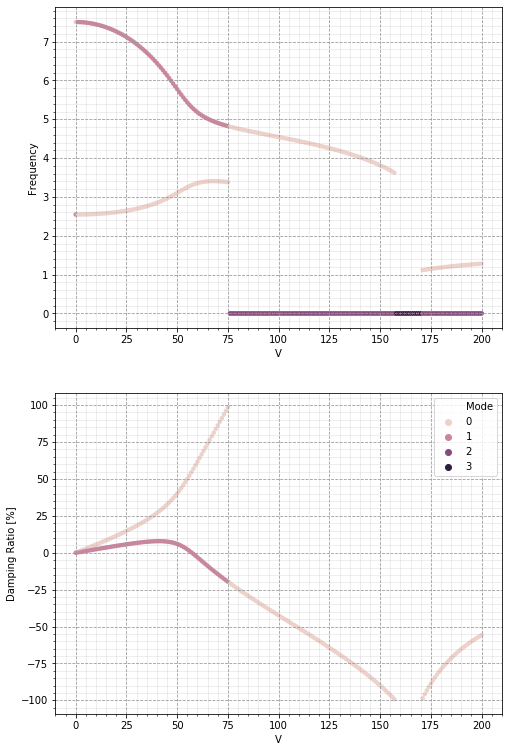

In [14]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
#data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
data = flutdfv2[flutdfv2['Stable']]
data = flutdfv2.copy()
data['Damping Ratio [%]'] = -data['Damping']*100
fig, axes = plt.subplots(2,1,figsize=(8,13))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False,edgecolor='none',s=20)
sns.scatterplot(data=data,x='V',y='Damping Ratio [%]',hue='Mode',ax=axes[1],edgecolor='none',s=20)
#sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',ax=axes[2])

for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
#axes[0].set(ylim=(0,75))
#axes[1].set(ylim=(-20,20))

In [210]:
flutdfv2[flutdfv2['Stable']]['V'].max()

In [211]:
2*p.s_0.value/p.c.value